In [10]:
import matplotlib.pyplot as plt
import numpy as np
import parmed as pmd
import time

# MosDef packages
import foyer
from foyer import Forcefield
import fresnel
import freud
import gsd
import gsd.hoomd
import gsd.fl
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import hoomd
import hoomd.md
import hoomd.group

In [4]:
# User inputs

In [5]:
def compound(smiles_string):
    
    comp_mb = mb.load(smiles_string, smiles = True) # creates an mbuild compound instance
    #comp_pmd = comp_mb.to_parmed() # convert the mbuild compound to a parmed compound
    #comp_mass = np.sum([atom.mass for atom in comp_pmd.atoms]) # Mass of the compound
    #comp_mb.mass = comp_mass # Update mb compound's mass

    #GAFF = foyer.forcefields.load_GAFF()
    #comp_typed = GAFF.apply(comp_mb, assert_dihedral_params=False)
    #for atom_pmd, atom_mb in zip(comp_typed, comp_mb):
    #    atom_mb.name = "{}".format(atom_pmd.type)
    return comp_mb

def build_box(compound, num_compounds):
    
    #TO DO: Add, and use density parameter to determine box edge lengths
    
    GAFF = foyer.forcefields.load_GAFF()
    box = mb.Box([10,10,10])
    system_box = mb.packing.fill_box(compound, num_compounds, box=box)
    system_box_pmd = system_box.to_parmed(box=box, infer_residues = True) # line 2347 of mbuild
    # What is happening here that breaks the ff information?
    system_box_pmd = GAFF.apply(system_box_pmd, assert_dihedral_params=False)
    
        # Why can't we start with an mbuild box of untyped compounds, then handle the typing here?
        # What is different about applying the ff to the box, vs creating a box with already typed molecules?
        # Where/How does Hoomd know which force field to use?
    
    return system_box_pmd

def sim(system, steps, kT, tau):
    log_quantities = ['temperature', 'pressure', 'volume', 'potential_energy', 'kinetic_energy']
    create_hoomd_simulation(system, r_cut=1.2, auto_scale=True)
    _all = hoomd.group.all()
    hoomd.md.integrate.mode_standard(dt=0.0001)
    integrator = hoomd.md.integrate.nvt(group=_all, kT=kT, tau=tau)
    integrator.randomize_velocities(seed=42)
    hoomd.analyze.log("trajectory.log", log_quantities, period=500, overwrite=True)
    hoomd.dump.gsd("start.gsd", period=None, group=_all, overwrite=True)
    hoomd.dump.gsd("traj.gsd", period=1e3, group=_all, phase=0, overwrite=True)
    hoomd.run(steps)
    hoomd.dump.gsd("out.gsd", period=None, group=_all, overwrite=True);



/home/chris/miniconda3/envs/mosdef-smiles/lib/python3.7/site-packages/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all proper dihedrals. Total system dihedrals: 13400, Parameterized dihedrals: 12600. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers.
  warnings.warn(msg)
/home/chris/miniconda3/envs/mosdef-smiles/lib/python3.7/site-packages/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 5600, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)
/home/chris/miniconda3/envs/mosdef-smiles/lib/python3.7/site-packages/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all proper dihedrals. Total system dihedrals: 20100, Parameterized dihedrals: 18900. Note that if your sys

[1.7690258026123047, 3.643519878387451, 5.405491590499878, 7.432129859924316, 9.399041652679443]


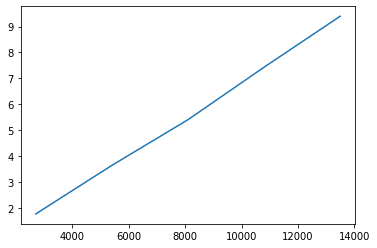

In [20]:
sizes = [100, 200, 300, 400, 500]
num_atoms = [i * 27 for i in sizes] # 27 atoms per p3ht molecule
times = []
for size in sizes:
    t0 = time.time()
    p3ht = compound('c1sccc1CCCCCC')
    system = build_box(p3ht, size)
    tf = time.time()
    times.append(tf - t0)
print(times)

0.0007064829490802906


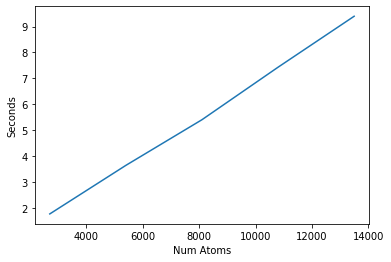

In [22]:
plt.plot(num_atoms, times)
plt.xlabel('Num Atoms')
plt.ylabel('Seconds')
slope = (times[-1] - times[0]) / (num_atoms[-1] - num_atoms[0])
print(slope)

In [5]:
p3ht = compound('c1sccc1CCCCCC')
system = build_box(p3ht, 30)
sim(system, steps=3e5, kT=1, tau=1)

/home/chris/miniconda3/envs/mosdef-smiles/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/home/chris/cme/mbuild/mbuild/compound.py:2749: UserWarning: No unitcell detected for pybel.Molecule c1sccc1CCCCCC	

  warn("No unitcell detected for pybel.Molecule {}".format(pybel_mol))
/home/chris/cme/forks/foyer/foyer/forcefield.py:433: UserWarning: No force field version number found in force field XML file.
  'No force field version number found in force field XML file.'
/home/chris/cme/forks/foyer/foyer/forcefield.py:445: UserWarning: No force field name found in force field XML file.
  'No force field name found in force field XML file.'
/home/chris/cme/forks/foyer/foyer/validator.py:132: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", Validatio

HOOMD-blue 2.9.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 02/04/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 810 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 3 exclusions             : 90
notice(2): Particles with 4 exclusions             : 390
notice(2): Particles with 6 exclusions             : 90
notice(2): Particles with 7 exclusions             : 60


/home/chris/cme/forks/foyer/foyer/forcefield.py:267: UserWarning: Parameters have not been assigned to all proper dihedrals. Total system dihedrals: 2010, Parameterized dihedrals: 1890. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers.
  warnings.warn(msg)
/home/chris/cme/forks/foyer/foyer/forcefield.py:267: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 840, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)


Time 00:00:20 | Step 34436 / 300000 | TPS 1770.79 | ETA 00:02:29
Time 00:00:30 | Step 51626 / 300000 | TPS 1718.96 | ETA 00:02:24
Time 00:00:40 | Step 68818 / 300000 | TPS 1719.13 | ETA 00:02:14
Time 00:00:50 | Step 85125 / 300000 | TPS 1630.65 | ETA 00:02:11
Time 00:01:00 | Step 101872 / 300000 | TPS 1674.65 | ETA 00:01:58
Time 00:01:10 | Step 118689 / 300000 | TPS 1681.7 | ETA 00:01:47
Time 00:01:20 | Step 135334 / 300000 | TPS 1664.49 | ETA 00:01:38
Time 00:01:30 | Step 153008 / 300000 | TPS 1767.34 | ETA 00:01:23
Time 00:01:40 | Step 169669 / 300000 | TPS 1666.06 | ETA 00:01:18
Time 00:01:50 | Step 186535 / 300000 | TPS 1686.57 | ETA 00:01:07
Time 00:02:00 | Step 203937 / 300000 | TPS 1740.17 | ETA 00:00:55
Time 00:02:10 | Step 220583 / 300000 | TPS 1664.59 | ETA 00:00:47
Time 00:02:20 | Step 238012 / 300000 | TPS 1742.9 | ETA 00:00:35
Time 00:02:30 | Step 254650 / 300000 | TPS 1663.77 | ETA 00:00:27
Time 00:02:40 | Step 272144 / 300000 | TPS 1749.35 | ETA 00:00:15
Time 00:02:50 | 

In [47]:
def rdf(gsd_file, types=['all'], num_frames=3, num_bins=10):
    
    gsd_file = gsd.fl.GSDFile(file, "rb", "MyApp", "hoomd", [1,0])
    trajectory = gsd.hoomd.HOOMDTrajectory(gsd_file)
    x, y, z = trajectory[-1].configuration.box[:3]
    r_max = x // 2
    freud_box = freud.box.Box(x, y, z)
    rdf = freud.density.RDF(r_max, num_bins)
    types = ['ss']
    for i in range(1, num_frames):
        frame = trajectory[-i]
        if types[0] == 'all':
            positions = frame.particles.position
        else:
            positions = []
            for idx, type_id in enumerate(frame.particles.typeid):
                if frame.particles.types[type_id] in types:
                    positions.append(frame.particles.position[idx])

        n_query = freud.locality.AABBQuery.from_system((freud_box, positions))
        rdf.compute(n_query, reset=False)
    x = rdf.bin_centers
    y = rdf.rdf
    return rdf


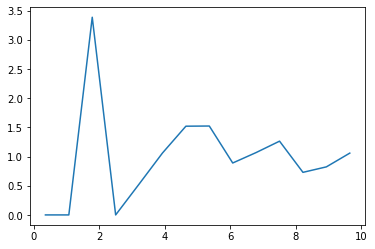

In [48]:
plt.plot(x_data, y_data)

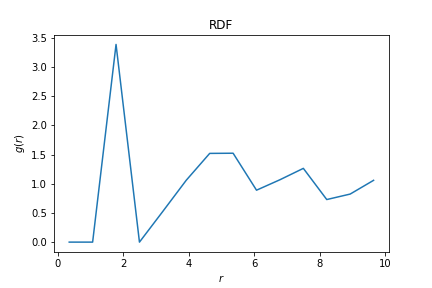

In [46]:
rdf

In [25]:
import fresnel
device = fresnel.Device(mode='cpu');
preview_tracer = fresnel.tracer.Preview(device, 300, 300, aa_level=3)
path_tracer = fresnel.tracer.Path(device, 300, 300)
blue = fresnel.color.linear([0.25,0.5,1])*0.9;
orange = fresnel.color.linear([1.0,0.714,0.169])*0.9
green = fresnel.color.linear([0.50,0.50,0.169])
red = fresnel.color.linear([0.64,0.33,.2126]);

def render_sphere_frame(frame, height=None):

    if height is None:
        if hasattr(frame, 'configuration'):
            Ly = frame.configuration.box[1]
            height = Ly * math.sqrt(3)
        else:
            Ly = frame.box.Ly;
            height = Ly * math.sqrt(3)

    scene = fresnel.Scene(device)
    scene.lights = fresnel.light.cloudy();
    g = fresnel.geometry.Sphere(scene, position=frame.particles.position, radius=numpy.ones(frame.particles.N)*0.5)
    g.material = fresnel.material.Material(solid=0.0, color=blue, primitive_color_mix=1.0, specular=1.0, roughness=0.2)
    g.outline_width = 0.07
    scene.camera = fresnel.camera.orthographic(position=(height, height, height), look_at=(0,0,0), up=(0,1,0), height=height)

    g.color[frame.particles.typeid == 0] = blue;
    g.color[frame.particles.typeid == 1] = orange;
    g.color[frame.particles.typeid == 2] = green;
    g.color[frame.particles.typeid == 3] = red;

    scene.background_color = (1,1,1)

    return path_tracer.sample(scene, samples=64, light_samples=20)

ModuleNotFoundError: No module named 'fresnel'

In [6]:
p3ht = compound('c1sccc1CCCCCC')
p3ht.visualize()

/home/chris/miniconda3/envs/mosdef-smiles/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/home/chris/cme/mbuild/mbuild/compound.py:2749: UserWarning: No unitcell detected for pybel.Molecule c1sccc1CCCCCC	

  warn("No unitcell detected for pybel.Molecule {}".format(pybel_mol))


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol